In [2]:
import torch
torch.cuda.set_device(5)
from rsnautils import *

nw = 8

In [3]:
fns = L(list(df_comb.fname)).map(filename)
splits = split_data(df_comb,0)

In [4]:
splits = (splits[0][:512],splits[1])

In [5]:
def get_data(bs, sz, use_wgt=False):
    return get_data_pil(fns, bs, splits=splits, sz=sz, use_hist=False, wgts = wgts if use_wgt else None)

In [6]:
pre = 'rn18_wgtd_freeze'
nm = ''
sz = None
bs = 128
arch = resnet18

In [7]:
dbunch = get_data(bs, sz)

In [8]:
# x,y = dbunch.one_batch()

In [9]:
learn = get_learner(dbunch, arch, get_loss(), pretrained=False)

In [9]:
learn.load(f'{pre}{nm}');

In [10]:
do_fit(learn, 1, 1e-7, freeze=False, div=1, pct_start=0)

RuntimeError: expected device cuda:5 but got device cpu

In [11]:
pres = 'rn18_wgtd_hist xrn50_wgtd-freeze xrn50_wgtd rn18_win rn18_win5 rn18_wgtd_freeze rn18_wgtd_no_pre'.split()

In [15]:
pres = 'rn18_wgtd rn18_wgtd_freeze rn18_wgtd_no_pre'.split()

In [16]:
for pre in pres:
    print(' --- ', pre)
    learn.load(f'{pre}{nm}')
    preds,targs = to_device(learn.get_preds(act=noop))
    print(lf2(preds,targs),accuracy_multi(preds,targs),accuracy_any(preds,targs))
    print(opt_val_loss(preds, targs, full=True))

 ---  rn18_wgtd


tensor(0.0715, device='cuda:5') tensor(0.9776, device='cuda:5') tensor(0.9587, device='cuda:5')
     fun: tensor(0.0694)
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: tensor(0.8196)
 ---  rn18_wgtd_freeze


tensor(0.0720, device='cuda:5') tensor(0.9773, device='cuda:5') tensor(0.9574, device='cuda:5')
     fun: tensor(0.0705)
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: tensor(0.8479)
 ---  rn18_wgtd_no_pre


tensor(0.0702, device='cuda:5') tensor(0.9774, device='cuda:5') tensor(0.9580, device='cuda:5')
     fun: tensor(0.0697)
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: tensor(0.9083)


In [17]:
pres = ['rn18_wgtd_freeze2']

In [18]:
for pre in pres:
    print(' --- ', pre)
    learn.load(f'{pre}{nm}')
    preds,targs = to_device(learn.get_preds(act=noop))
    print(lf2(preds,targs),accuracy_multi(preds,targs),accuracy_any(preds,targs))
    print(opt_val_loss(preds, targs, full=True))

 ---  rn18_wgtd_freeze2


tensor(0.0697, device='cuda:5') tensor(0.9777, device='cuda:5') tensor(0.9584, device='cuda:5')
     fun: tensor(0.0691)
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: tensor(0.8979)


In [81]:
test_fns = [(path_tst/f'{filename(o)}.jpg').absolute() for o in df_tst.fname.values]
tst = test_dl(learn.dbunch, test_fns)

In [95]:
pre = 'rn18_wgtd_no_pre'
nm = ''

In [96]:
learn.load(f'{pre}{nm}');

In [97]:
preds,targs = learn.get_preds(dl=tst)

In [98]:
preds_scl = (logit(preds)*0.91).sigmoid()

In [99]:
probs = preds_scl.clamp(1e-5,1-1e-5)

In [100]:
pred_csv = submission(df_tst, probs)

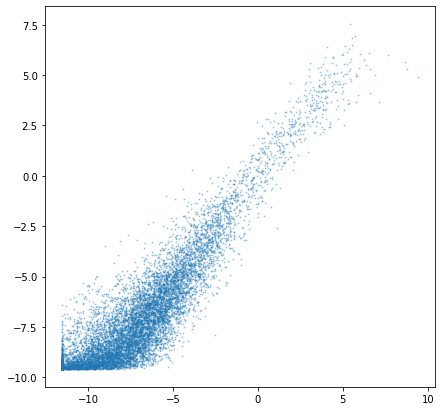

In [101]:
prev_csv = pd.read_csv('subm/subm_avg.csv')
pred2_df = pred_csv.merge(prev_csv, on='ID')
pred2_samp = pred2_df.sample(10000)
np.corrcoef(pred2_samp.Label_x.astype(np.float64),pred2_samp.Label_y, rowvar=False)

x,y = tensor(pred2_samp.Label_x.astype(np.float32)),tensor(pred2_samp.Label_y.astype(np.float32))
plt.figure(figsize=(7,7))
plt.scatter(logit(x),logit(y), s=1, alpha=0.3);

In [102]:
nm = pre
pred_csv.to_csv(f'subm/{nm}.csv', index=False)
pre

'rn18_wgtd_no_pre'

In [103]:
from IPython.display import FileLink, FileLinks
FileLink(f'subm/{nm}.csv')

/home/jhoward/git/rsna_brain/subm/rn18_wgtd_no_pre.csv

In [105]:
from kaggle import api
api.competition_submit(f'subm/{nm}.csv', f'0.0697,{pre} (scl)', 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 16.9M/16.9M [00:03<00:00, 5.51MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection